In [1]:
! pip install pandas

In [2]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [3]:
!pip install keras

In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [41]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Malaria/Dataset/Train'
valid_path = '/content/drive/My Drive/Malaria/Dataset/Test'

In [42]:
# Import the VGG19 library as shown below and add preprocessing layer to the front of VGG19",
# Here we will be using imagenet weights\n"
vgg= VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [44]:
# don't train existing weights\n",
for layer in vgg.layers:
    layer.trainable = False

In [45]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Malaria/Dataset/Train/*')
len(folders)

2

In [46]:
folders[0]

'/content/drive/My Drive/Malaria/Dataset/Train/Parasite'

In [47]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [48]:
prediction=Dense(len(folders), activation='softmax')(x)

In [49]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [50]:

# view the structure of the model
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [51]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [53]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Malaria/Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [54]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Malaria/Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [55]:

# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
13/13 [==============================] - 6s 443ms/step - loss: 1.8229 - accuracy: 0.4904 - val_loss: 0.7370 - val_accuracy: 0.6791
Epoch 2/50
13/13 [==============================] - 6s 439ms/step - loss: 0.7607 - accuracy: 0.6082 - val_loss: 0.4854 - val_accuracy: 0.7463
Epoch 3/50
13/13 [==============================] - 6s 438ms/step - loss: 0.4792 - accuracy: 0.7764 - val_loss: 0.4493 - val_accuracy: 0.7239
Epoch 4/50
13/13 [==============================] - 5s 419ms/step - loss: 0.3617 - accuracy: 0.8630 - val_loss: 0.5823 - val_accuracy: 0.7164
Epoch 5/50
13/13 [==============================] - 6s 427ms/step - loss: 0.3424 - accuracy: 0.8606 - val_loss: 0.3880 - val_accuracy: 0.7687
Epoch 6/50
13/13 [==============================] - 6s 427ms/step - loss: 0.3036 - accuracy: 0.8894 - val_loss: 0.4413 - val_accuracy: 0.8060
Epoch 7/50
13/13 [==============================] - 6s 426ms/step - loss: 0.2778 - accuracy: 0.9062 - val_loss: 0.3511 - val_accuracy: 0.8358
Epoch 

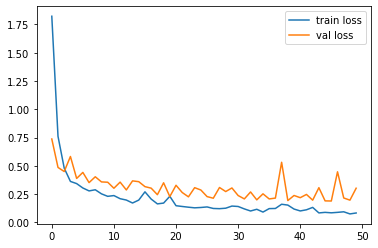

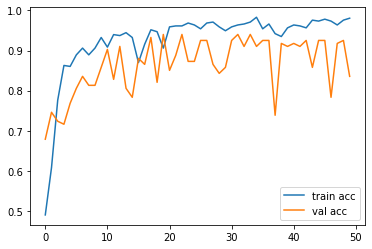

<Figure size 432x288 with 0 Axes>

In [56]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [57]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('maleria_model_vgg19.h5')

In [58]:
y_pred = model.predict(test_set)

In [59]:
y_pred

array([[3.73702683e-02, 9.62629795e-01],
       [1.13356542e-02, 9.88664329e-01],
       [8.38763833e-01, 1.61236212e-01],
       [9.70228791e-01, 2.97711492e-02],
       [9.14817631e-01, 8.51823986e-02],
       [9.66495216e-01, 3.35048661e-02],
       [2.07088608e-02, 9.79291141e-01],
       [1.06692933e-01, 8.93307090e-01],
       [6.75007045e-01, 3.24992955e-01],
       [4.50140119e-01, 5.49859881e-01],
       [9.99992728e-01, 7.27082443e-06],
       [8.15479010e-02, 9.18452144e-01],
       [8.38733494e-01, 1.61266506e-01],
       [9.81568396e-01, 1.84316058e-02],
       [5.78508019e-01, 4.21491951e-01],
       [9.97941911e-01, 2.05807551e-03],
       [9.06848669e-01, 9.31512490e-02],
       [2.69856334e-01, 7.30143666e-01],
       [9.77467000e-01, 2.25330703e-02],
       [9.92245413e-03, 9.90077496e-01],
       [4.88083363e-01, 5.11916637e-01],
       [2.86667682e-02, 9.71333265e-01],
       [1.16049878e-01, 8.83950114e-01],
       [4.40551452e-02, 9.55944836e-01],
       [5.032382

In [60]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [61]:
y_pred

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0])

In [62]:
len(y_pred)

134

In [63]:
np.array(y_pred==0).sum()

71

In [147]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [169]:
model=load_model('maleria_model_vgg19.h5')

In [180]:
img=image.load_img('/content/drive/My Drive/Malaria/Dataset/Test/Parasite/C39P4thinF_original_IMG_20150622_105803_cell_106.png',target_size=(224,224))


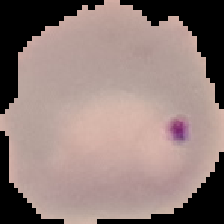

In [181]:
img

In [182]:
y=image.img_to_array(img)
y


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [183]:
y.shape

(224, 224, 3)

In [184]:
y=np.expand_dims(y,axis=0)
y.shape

(1, 224, 224, 3)

In [185]:
imgy=preprocess_input(y)
imgy.shape

(1, 224, 224, 3)

In [186]:
imgy=imgy/255


In [187]:
preds= model.predict(imgy)
preds



array([[0.89126515, 0.10873483]], dtype=float32)

In [188]:
a=np.argmax(preds, axis=1)
a

array([0])

In [189]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Infected
